# Demo Notebook to see feature construction and visualize them
In this notebook you can choose the idx of a specific dam, look at its data, create the features and save all the necessary elements to perform IRL

In [2]:
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import pickle 
import calendar
import os
from datetime import datetime, timedelta
from utils import plot_ts, plot_med_mean, plot_med_mean_double, coeff_estimator 
from utils import preprocess, mask_funct, sigmoid, feature_build
import warnings
import subprocess
import sys
from subprocess import PIPE

plt.close('all')
plt.style.use('default')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})

warnings.filterwarnings('ignore')

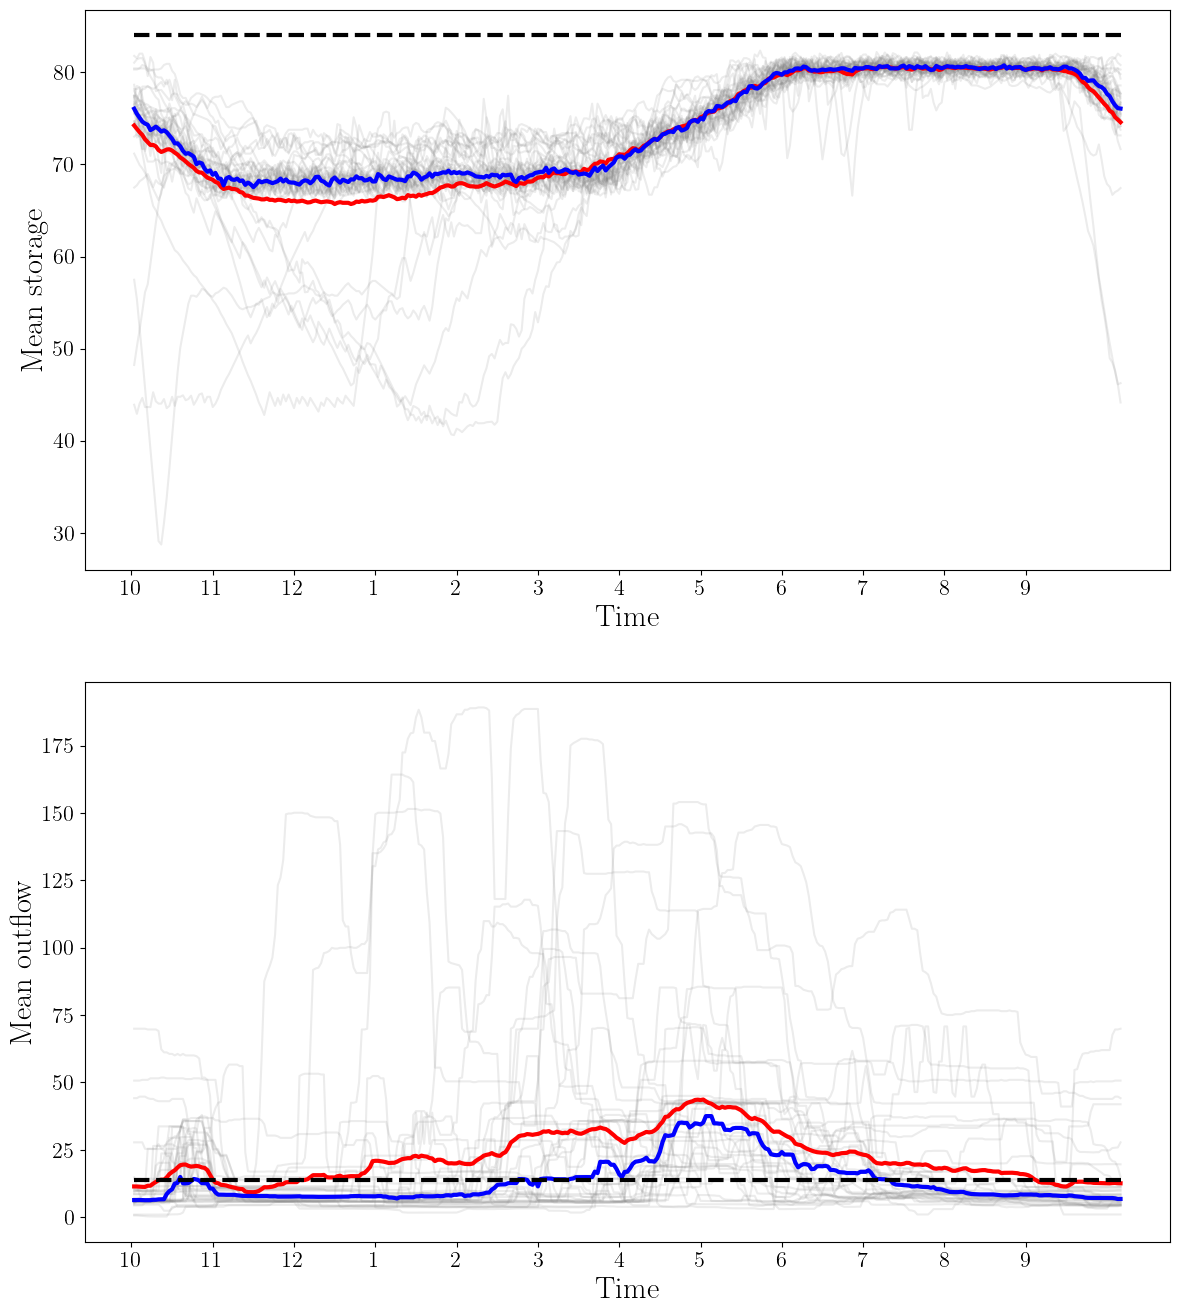

In [4]:
dataset_number = 204

base_dir = '../ResOpsUS/data/' + str(dataset_number) + "/"
logs_dir = '../logs/ResOpsUS/' + str(dataset_number) + "/"

if not os.path.exists(base_dir):
    os.makedirs(base_dir)

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

data = pd.read_csv('../ResOpsUS/time_series/' + "ResOpsUS_" + str(dataset_number) + ".csv", delimiter=',')

# We retrieve max_storage from GRanD dataset
G = pd.read_excel("../ResOpsUS/GRanD_dams_v1_3.xls")
max_storage = int(G.iloc[dataset_number - 1]["NEW_STORAGE"])

# We preprocess the data again just to be sure
data, uniq = preprocess(data)

# We plot the time series of storage and outflow
plot_med_mean_double(data, "storage", "outflow", uniq, max_storage)

## We define the state features and some auxiliary variables
The state is represented by the storage, the five last actions taken and a dummy variable for each month that indicate in which month we are.

In [5]:
min_max_scaler = MinMaxScaler()

n_year = len(np.unique(data['water_year']))

#Summary Statistics
mean_outflow= data.groupby('n_day_water').mean()["outflow"].values
median_outflow= data.groupby('n_day_water').median()["outflow"].values
global_mean = np.mean(median_outflow)
data["mean_outflow"] = np.tile(mean_outflow, int(data.shape[0] / 365))
data["median_outflow"] = np.tile(median_outflow, int(data.shape[0] / 365))
data["global_mean"] = np.tile(global_mean, n_year * 365)
data["diff_med_mean"] = data["mean_outflow"] - data["median_outflow"]    
    
#Actions
action = data['outflow'].values.ravel()

#Day and Month
months = pd.get_dummies(data['month']).values
day = data['n_day_water'].values.ravel()
 
#State features
storage = data['storage'].values.ravel()
old1_action = np.concatenate(([action[0]], action[:-1]))
old2_action = np.concatenate(([old1_action[0]], old1_action[:-1]))
old3_action = np.concatenate(([old2_action[0]], old2_action[:-1]))
old4_action = np.concatenate(([old3_action[0]], old3_action[:-1]))
old5_action = np.concatenate(([old4_action[0]], old4_action[:-1]))

state = np.array([storage, old1_action, old2_action, 
                  old3_action, old4_action, old5_action]).T

state = np.concatenate((state, months), axis = 1)

## 10th-90th InterQuartile Range Computation for Outflow and Storage

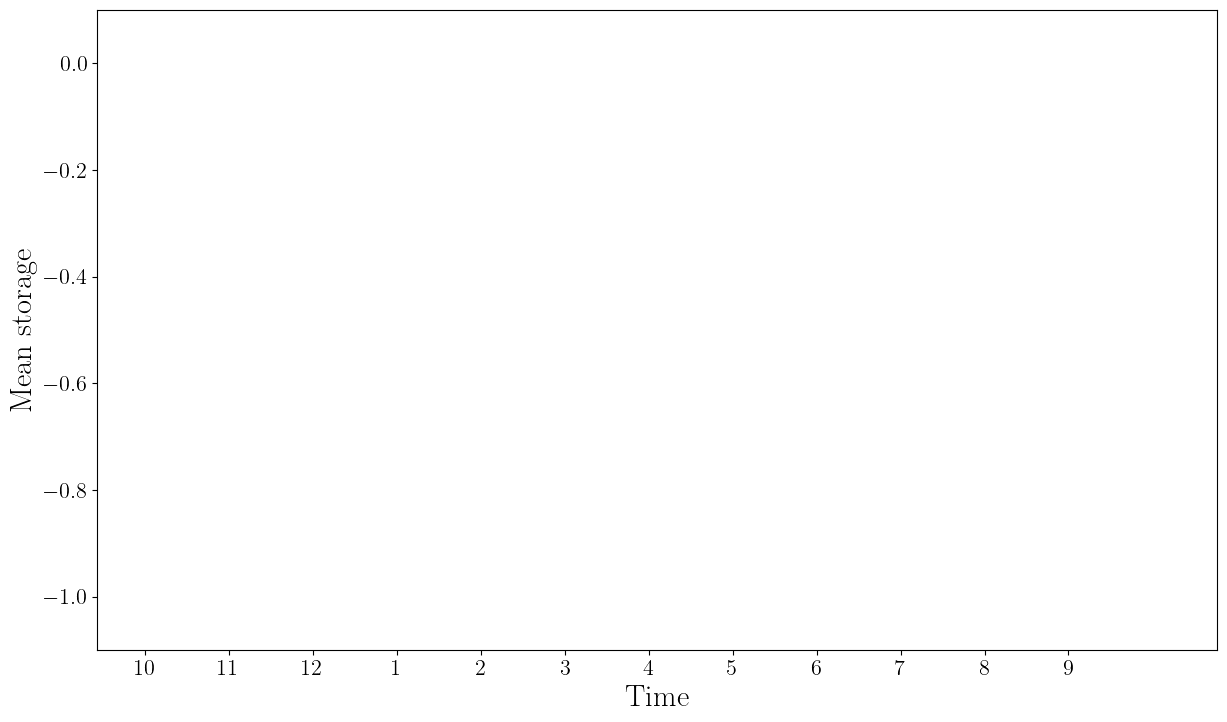

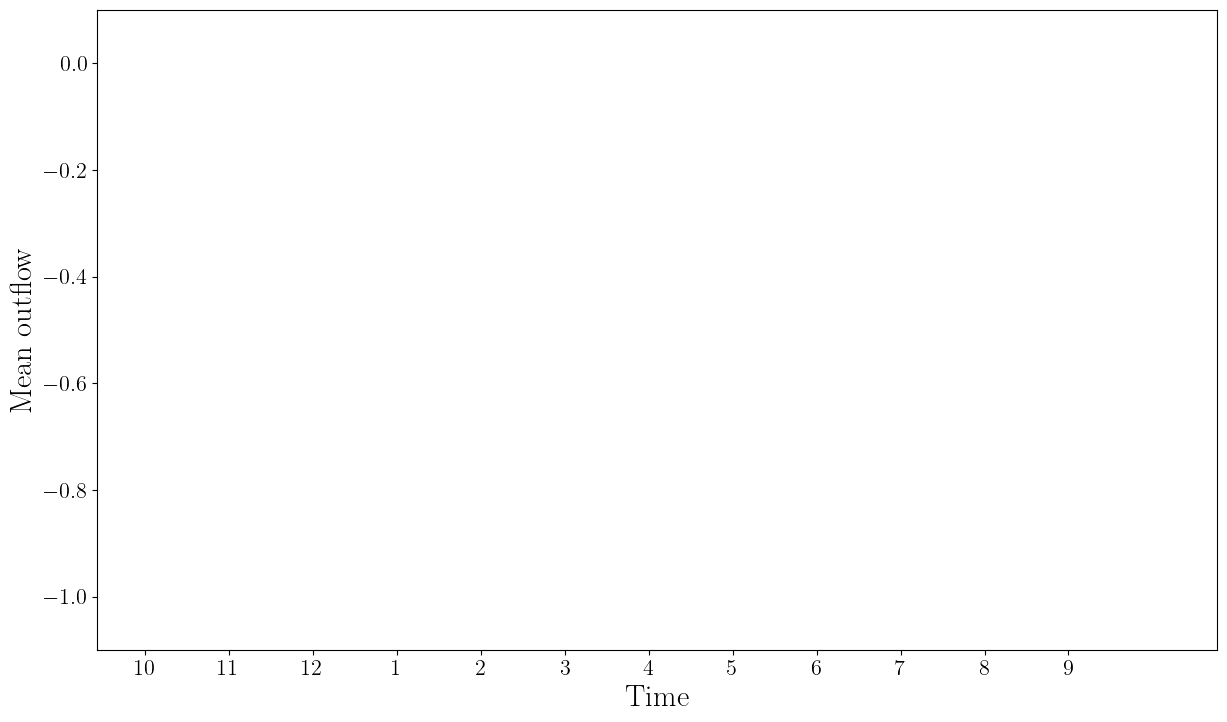

In [6]:
# Outflow
iqr_outflow = np.zeros(365)
q90_outflow = np.zeros(365)
q10_outflow = np.zeros(365)

for i in range(365):
    q90_outflow[i], q10_outflow[i] = np.percentile(action.reshape(-1, 365)[:, i], [90, 10])
    iqr_outflow[i] = q90_outflow[i] - q10_outflow[i]
    
#Storage
iqr_stor = np.zeros(365)
q90_stor = np.zeros(365)
q10_stor = np.zeros(365)

for i in range(365):
    q90_stor[i], q10_stor[i] = np.percentile(storage.reshape(-1, 365)[:, i], [90, 10])
    iqr_stor[i] = q90_stor[i] - q10_stor[i]

iqr_stor = np.tile((iqr_stor), int(len(action) / 365)) + 1e-5

plot_med_mean(data, "storage", uniq, max_storage = max_storage, q75=q90_stor, q25=q10_stor)
plot_med_mean(data, "outflow", uniq, max_storage = max_storage, q75=q90_outflow, q25=q10_outflow)

## Feature Construction


In [7]:
m = coeff_estimator(X=data["n_day_water"], y=data["storage"], window_size=10)
threshold = (max_storage / 365)
median_ = data.groupby('n_day_water').median()["storage"].values
max_outflow = np.quantile(data["outflow"], 0.99)

### IRRIGATION FEATURE

# Mask to divide the first months from the last ones
days = data["n_day"]
max_ = np.argmax(data.groupby('n_day').median()["storage"].values)

delta = np.max(median_) - np.min(median_)
sig_delta = sigmoid(inflection=0.1 * max_storage, max_q=5 * max_storage, left=3, right=1 / 3, increasing=False)
factor = sig_delta(delta)

if max_ not in range(100, 280):
    max_ = 190

start = max_ - 60
end = max_ + 120
if end > 365:
    end = 365
f_outflow = mask_funct(inflection_1=start, inflection_2=end, max_q=365,
                       left=-1, center=1, right=-1)
mask_year = f_outflow(days)

windowed_data = data[(data["n_day"] > start) & (data["n_day"] < end)]
max_outflow_window = np.max(windowed_data.groupby('n_day').median()["outflow"].values)

windowed_data = data[~((data["n_day"] > start) & (data["n_day"] < end))]
min_outflow_window = np.min(windowed_data.groupby('n_day').median()["outflow"].values)

delta_outflow = max_outflow_window - min_outflow_window
sig_delta_outflow = sigmoid(inflection=0.3 * max_outflow, max_q=5 * max_outflow, left=1, right=1 / 3,
                            increasing=False)
factor_outflow = sig_delta_outflow(delta_outflow)

## MAIN COMPONENT
feature_irr = (action - global_mean)
feature_irr = feature_irr * mask_year

## MULTIPLICATIVE FACTOR
# Increasing storage in 4-5-6
start = max_ - 60
end = max_
f_day = mask_funct(inflection_1=start, inflection_2=end, max_q=365,
                   left=0, center=1, right=0)
mask_first_months = f_day(days)

sig_increasing_pos = sigmoid(inflection=threshold, max_q=0.1 * abs(np.max(m) - np.min(m)), left=1, right=2)
mask_increasing_pos = sig_increasing_pos(m)

sig_increasing_neg = sigmoid(inflection=threshold, max_q=0.1 * abs(np.max(m) - np.min(m)), left=1, right=1 / 4,
                             increasing=False)
mask_increasing_neg = sig_increasing_neg(m)

mask_increasing_pos = np.ones(len(days)) * (1 - mask_first_months) + mask_increasing_pos * (mask_first_months)
mask_increasing_neg = np.ones(len(days)) * (1 - mask_first_months) + mask_increasing_neg * (mask_first_months)

## MULTIPLICATIVE FACTOR
# Decreasing storage in 7-8-9
start = max_
end = max_ + 120
if end > 365:
    end = 365
f_day = mask_funct(inflection_1=start, inflection_2=end, max_q=365,
                   left=0, center=1, right=0)
mask_last_months = f_day(days)

sig_decreasing_pos = sigmoid(inflection=- threshold, max_q=abs(np.max(m) - np.min(m)), left=2, right=1,
                             increasing=False)
mask_decreasing_pos = sig_decreasing_pos(m)

sig_decreasing_neg = sigmoid(inflection=- threshold, max_q=abs(np.max(m) - np.min(m)), left=1 / 4, right=1,
                             increasing=True)
mask_decreasing_neg = sig_decreasing_neg(m)

mask_decreasing_pos = np.ones(len(days)) * (1 - mask_last_months) + mask_decreasing_pos * (mask_last_months)
mask_decreasing_neg = np.ones(len(days)) * (1 - mask_last_months) + mask_decreasing_neg * (mask_last_months)

feature_irr[feature_irr > 0] = feature_irr[feature_irr > 0] * mask_increasing_pos[feature_irr > 0] * \
                                     mask_decreasing_pos[feature_irr > 0] * factor
feature_irr[feature_irr < 0] = feature_irr[feature_irr < 0] * mask_increasing_neg[feature_irr < 0] * \
                                     mask_decreasing_neg[feature_irr < 0] * factor * factor_outflow

# Mean to preserve smoothness
old_feature_irr = np.concatenate(([feature_irr[0]], feature_irr[:-1]))
old_old_feature_irr = np.concatenate(([old_feature_irr[0]], old_feature_irr[:-1]))
feature_irr = 1 / 3 * (old_old_feature_irr + old_feature_irr + feature_irr)



## HYDRO

sig_hydro = sigmoid(inflection=0.05 * max_storage, max_q=1/2 * max_outflow, left=1 / 4, right=1)
factor_hydro = sig_hydro(np.max(iqr_stor))

modest_outflow = 0.1 * max_outflow

# Mask to increase reward if water storage is HIGH
sig_storage = sigmoid(inflection=0.7 * max_storage, max_q=max_storage, left=1, right=2)
mask_storage = sig_storage(data["storage"])

# Mask to decrease reward if water storage is LOW
sig_storage_low_neg = sigmoid(inflection=0.5 * max_storage, max_q=5 * max_storage, left=2, right=1,
                              increasing=False)
mask_storage_low_neg = sig_storage_low_neg(data["storage"])

# Mask to increase reward if water storage is CONSTANT
f_const = mask_funct(inflection_1=- threshold, inflection_2=threshold, max_q=0.1 * abs(np.max(m) - np.min(m)),
                     left=0.5, center=1.5, right=0.5)
mask_const = f_const(m)

feature_hydro = (action - modest_outflow)
# mask_storage_low_neg = np.ones(len(days)) * (1 - mask_const) + mask_storage_low_neg * (mask_const)

feature_hydro[feature_hydro > 0] = feature_hydro[feature_hydro > 0] * mask_const[feature_hydro > 0] * mask_storage[
    feature_hydro > 0] * factor_hydro

feature_hydro[feature_hydro < 0] = feature_hydro[feature_hydro < 0] * mask_storage_low_neg[
    feature_hydro < 0] * factor_hydro

# Mean to preserve smoothness
old_feature_hydro = np.concatenate(([feature_hydro[0]], feature_hydro[:-1]))
old_old_feature_hydro = np.concatenate(([old_feature_hydro[0]], old_feature_hydro[:-1]))
feature_hydro = 1 / 3 * (old_old_feature_hydro + old_feature_hydro + feature_hydro)



## FLOOD

# Penalize if you don't produce enough energy
scaling_factor = np.sqrt(np.mean(data["diff_med_mean"]))
if scaling_factor > 1:
    modest_outflow_flood = modest_outflow / scaling_factor
else:
    modest_outflow_flood = modest_outflow

# Mask to decrease reward if water storage is HIGH
sig_storage_high = sigmoid(inflection=0.5 * max_storage, max_q=max_storage, left=1, right=-1, increasing=False)
mask_storage_high = sig_storage_high(data["storage"])

# Mask to increase reward if water storage is LOW
sig_storage_low_pos = sigmoid(inflection=0.3 * max_storage, max_q=max_storage, left=2, right=1, increasing=False)
mask_storage_low_pos = sig_storage_low_pos(data["storage"])

# Mask to increase reward if water storage is LOW
sig_storage_low_neg = sigmoid(inflection=0.3 * max_storage, max_q=5 * max_storage, left=1 / 2, right=1,
                              increasing=True)
mask_storage_low_neg = sig_storage_low_neg(data["storage"])

# Mask to see if water storage is CONSTANT
f_const = mask_funct(inflection_1=- threshold, inflection_2=threshold, max_q=abs(np.max(m) - np.min(m)),
                     left=0, center=1, right=0)
mask_const = f_const(m)

# Mask to PENALIZE if water storage is VERY HIGH
sig_storage_very_high = sigmoid(inflection=0.9 * max_storage, max_q=max_storage, left=1, right=- 0.2,
                                increasing=False)
mask_storage_very_high = sig_storage_very_high(data["storage"])

# Mask to increase reward if mean is greater than median
sig_mean_med = sigmoid(inflection=0.2 * max(data["diff_med_mean"]), max_q=max(data["diff_med_mean"]), left=1,
                       right=2)
mask_mean_med = sig_mean_med(data["storage"])

mask_storage_high = np.ones(len(days)) * (1 - mask_const) + mask_storage_high * (mask_const)
mask_storage_low_pos = np.ones(len(days)) * (1 - mask_const) + mask_storage_low_pos * (mask_const)
mask_storage_low_neg = np.ones(len(days)) * (1 - mask_const) + mask_storage_low_neg * (mask_const)

# mask_storage_low = mask_storage_low - (mask_storage_low - 1) * (1 - mask_const)

feature_flood = (action - modest_outflow_flood)

feature_flood[feature_flood > 0] = feature_flood[feature_flood > 0] * mask_storage_high[feature_flood > 0]
feature_flood[feature_flood > 0] = feature_flood[feature_flood > 0] * mask_storage_low_pos[feature_flood > 0]
feature_flood[feature_flood < 0] = feature_flood[feature_flood < 0] * mask_storage_low_neg[feature_flood < 0]

feature_flood[feature_flood > 0] = feature_flood[feature_flood > 0] * mask_storage_very_high[feature_flood > 0]
feature_flood[feature_flood > 0] = feature_flood[feature_flood > 0] * mask_mean_med[feature_flood > 0]

# Mean to preserve smoothness
old_feature_flood = np.concatenate(([feature_flood[0]], feature_flood[:-1]))
old_old_feature_flood = np.concatenate(([old_feature_flood[0]], old_feature_flood[:-1]))
feature_flood = 1 / 3 * (old_old_feature_flood + old_feature_flood + feature_flood)



## FEATURE AGGREGATION & NORMALIZATION 

data["rew_irr"] = feature_irr
data["rew_hydro"] = feature_hydro
data["rew_flood"] = feature_flood

mean_irr = data.groupby('n_day_water').mean()["rew_irr"].values
median_irr = data.groupby('n_day_water').median()["rew_irr"].values

mean_hydro = data.groupby('n_day_water').mean()["rew_hydro"].values
median_hydro = data.groupby('n_day_water').median()["rew_hydro"].values

mean_flood = data.groupby('n_day_water').mean()["rew_flood"].values
median_flood = data.groupby('n_day_water').median()["rew_flood"].values

max_feat = max(max(median_irr), max(median_hydro), max(median_flood))
min_feat = min(min(median_irr), min(median_hydro), min(median_flood))

all_rewards = np.concatenate((feature_irr, feature_hydro, feature_flood))
inflection = np.quantile(all_rewards[all_rewards > 0], 0.7)
sig_normalize = sigmoid(inflection=inflection, max_q=5 * max_feat, left=0, right=0.01)

feature_irr[feature_irr > 0] = 0
feature_hydro[feature_hydro > 0] = 0
feature_flood[feature_flood > 0] = 0

feature_irr[feature_irr < 0] = feature_irr[feature_irr < 0] / np.abs(min_feat)
feature_hydro[feature_hydro < 0] = feature_hydro[feature_hydro < 0] / np.abs(min_feat)
feature_flood[feature_flood < 0] = feature_flood[feature_flood < 0] / np.abs(min_feat)

feature_irr[feature_irr < -1] = -1
feature_hydro[feature_hydro < -1] = -1
feature_flood[feature_flood < -1] = -1

feature_irr[feature_irr < np.quantile(feature_irr[feature_irr < 0], 0.05)] = 0
try:
    feature_hydro[feature_hydro < np.quantile(feature_hydro[feature_hydro < 0], 0.05)] = 0
except IndexError:
    pass
feature_flood[feature_flood < np.quantile(feature_flood[feature_flood < 0], 0.05)] = 0

feature_hydro = feature_hydro[:, None]
feature_flood = feature_flood[:, None]
feature_irr = feature_irr[:, None]

reward_features = np.hstack([feature_irr, feature_hydro, feature_flood])

#scale states
state_before_scaling = state
state = min_max_scaler.fit_transform(state)
action_before_scaling = action
action = min_max_scaler.fit_transform(action[:, None])

#np.save(base_dir + 'states.npy', state)
#np.save(base_dir + 'actions.npy', action_before_scaling[:, None])
#np.save(base_dir + 'reward_features.npy', reward_features)

0
1
2
3
4
5
6
7
8
9


## Plot of the features

In [8]:
data["rew_irr"] = reward_features[:,0]
data["rew_hydro"] = reward_features[:,1]
data["rew_flood"] = reward_features[:,2]

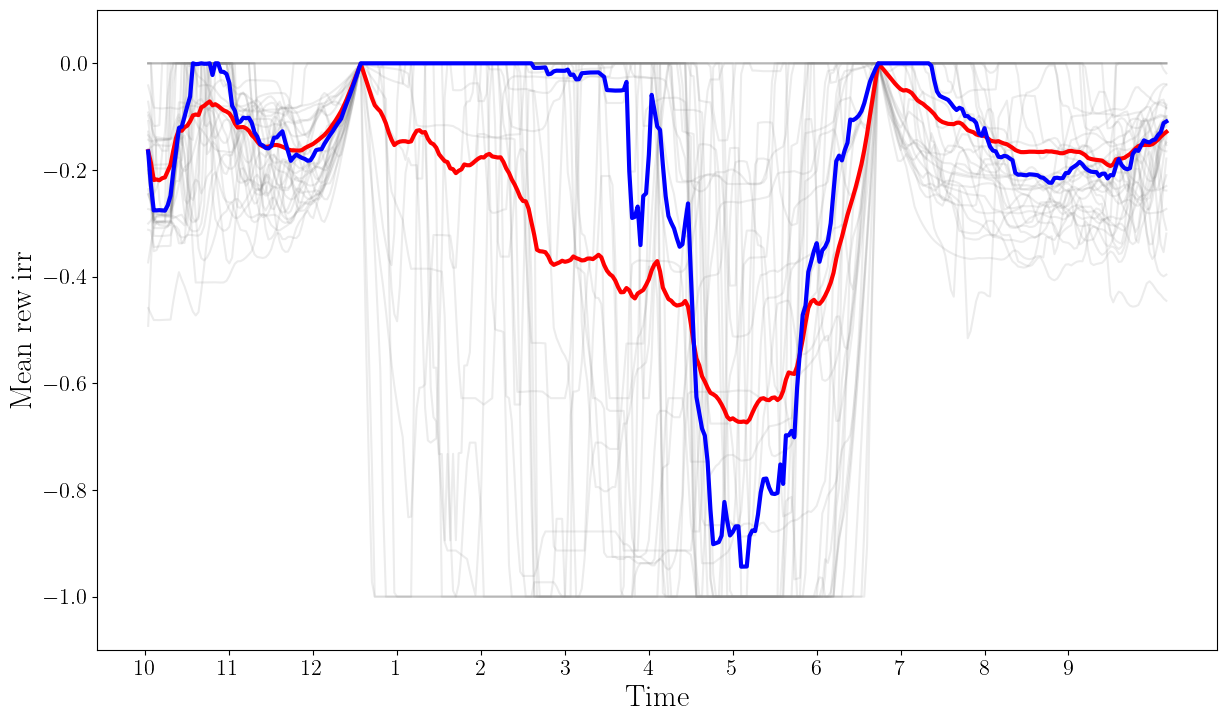

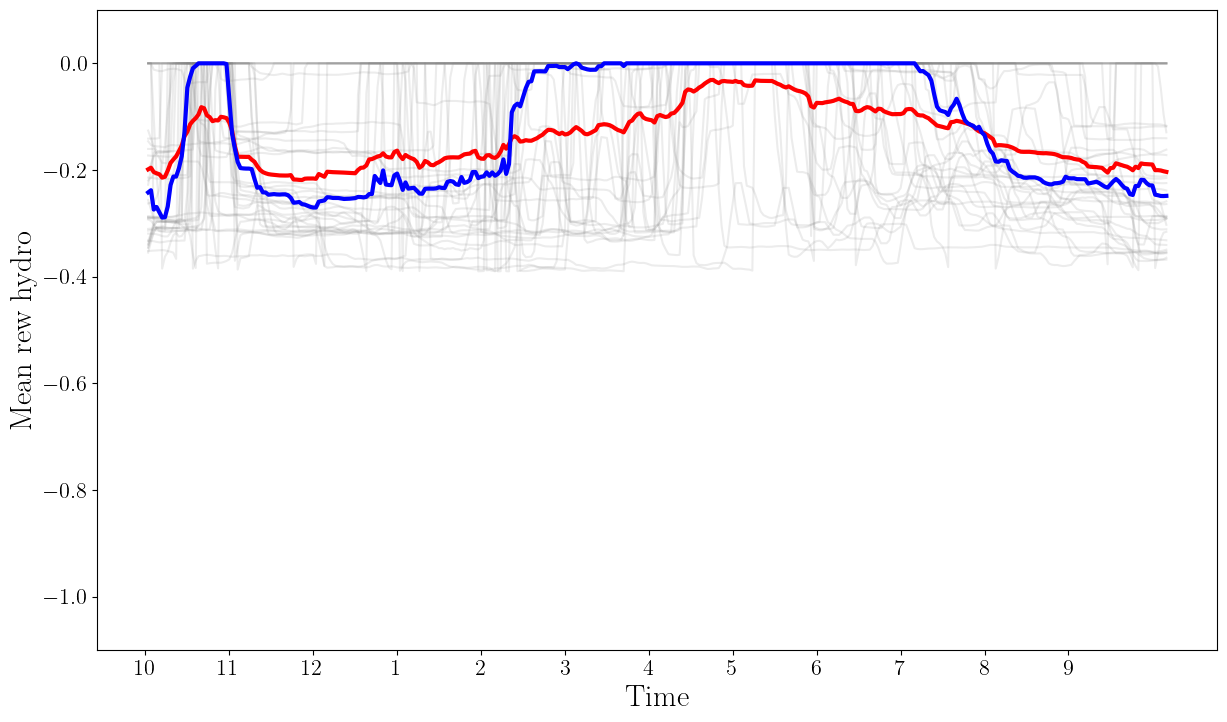

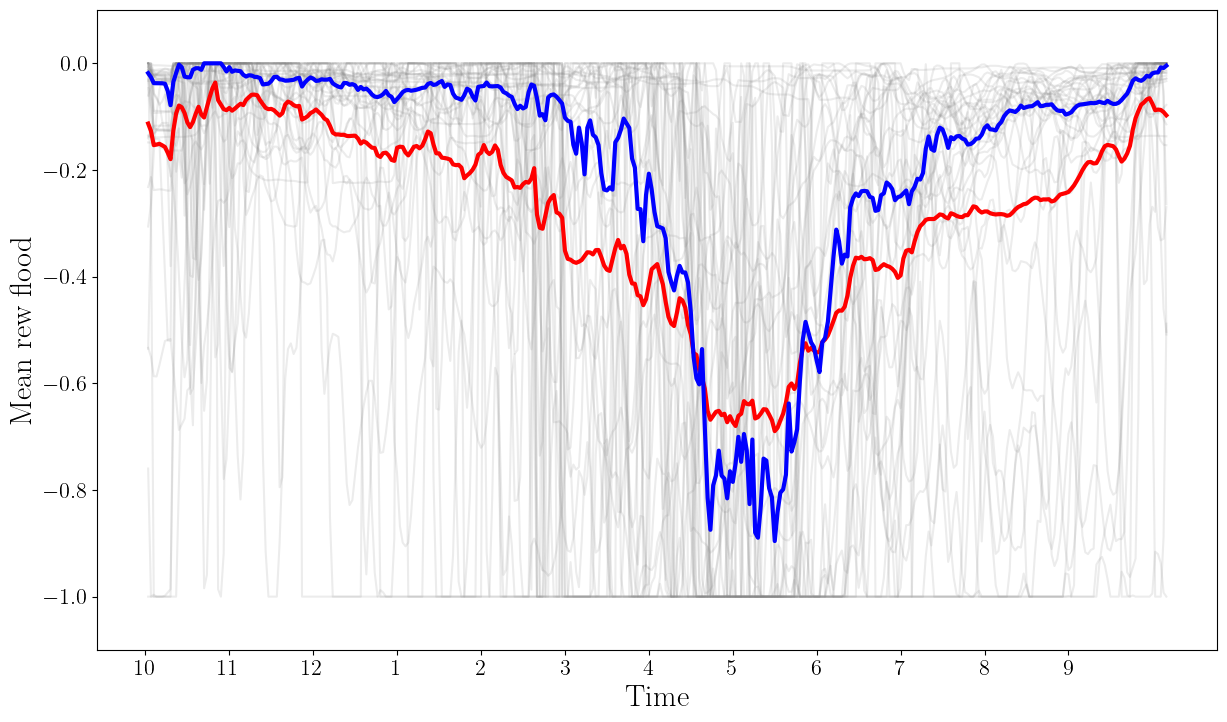

In [9]:
plot_med_mean(data, "rew_irr", uniq)
plot_med_mean(data, "rew_hydro", uniq)
plot_med_mean(data, "rew_flood", uniq)

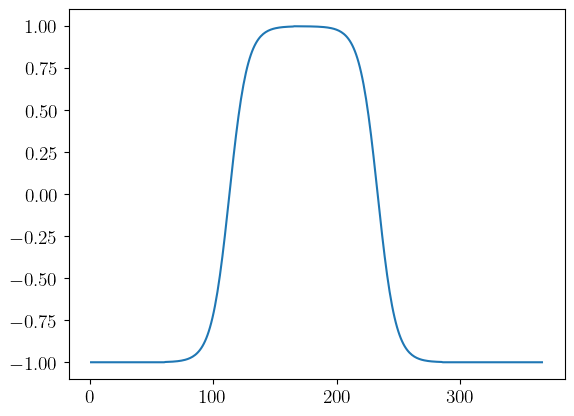

In [55]:
f_outflow = mask_funct(inflection_1=start, inflection_2=end, max_q=365,
                       left=-1, center=1, right=-1)
mask_year = f_outflow(days)
plt.plot(np.linspace(1,366, 365), 
         f_outflow(np.linspace(1,366, 365)))


In [ ]:
i = 34

sig_storage_low_neg = sigmoid(inflection=0.5 * max_storage, max_q=5 * max_storage, left=2, right=1,
                              increasing=False)
#mask_storage_low_neg = sig_storage_low_neg(data["storage"])

# Mask to see if water storage is CONSTANT
f_const = mask_funct(inflection_1=- threshold, inflection_2=threshold, max_q=abs(np.max(m) - np.min(m)),
                     left=0, center=1, right=0)
mask_const = f_const(m)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.linspace(0,max_storage, 365), 
         sig_storage_low_neg(np.linspace(0,max_storage, 365)))
#ax1.axvline(x=150)
ax1.set_title("Sigmoid low storage")
#ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("Mask low storage")
ax2.plot(np.arange(0,365), mask_storage_low_neg[i * 365: (i + 1) * 365])
ax2.set_ylim(0.9,2.1)


(-1.1, 1.1)

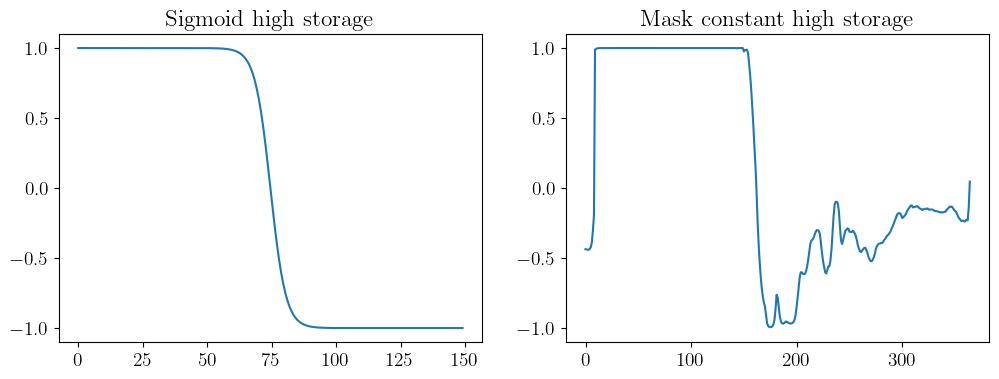

In [37]:
i = 22

# Mask to decrease reward if water storage is HIGH
sig_storage_high = sigmoid(inflection=0.5 * max_storage, max_q=max_storage, left=1, right=-1, increasing=False)
mask_storage_high = sig_storage_high(data["storage"])

mask_storage_high = np.ones(len(days)) * (1 - mask_const) + mask_storage_high * (mask_const)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.linspace(0,max_storage, 365), 
         sig_storage_high(np.linspace(0,max_storage, 365)))
#ax1.axvline(x=150)
ax1.set_title("Sigmoid high storage")
#ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("Mask constant high storage")
ax2.plot(np.arange(0,365), mask_storage_high[i * 365: (i + 1) * 365])
ax2.set_ylim(-1.1,1.1)

(0.5, 1.05)

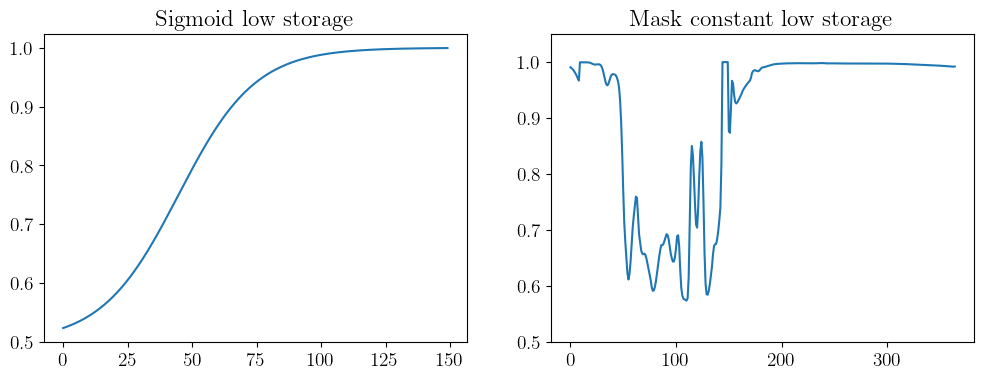

In [41]:
i = 22

# Mask to increase reward if water storage is LOW
sig_storage_low_neg = sigmoid(inflection=0.3 * max_storage, max_q=5 * max_storage, left=1 / 2, right=1,
                              increasing=True)
mask_storage_low_neg = sig_storage_low_neg(data["storage"])

mask_storage_low_neg = np.ones(len(days)) * (1 - mask_const) + mask_storage_low_neg * (mask_const)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.linspace(0,max_storage, 365), 
         sig_storage_low_neg(np.linspace(0,max_storage, 365)))
#ax1.axvline(x=150)
ax1.set_title("Sigmoid low storage")
#ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("Mask constant low storage")
ax2.plot(np.arange(0,365), mask_storage_low_neg[i * 365: (i + 1) * 365])
ax2.set_ylim(1/2,1.05)

In [ ]:
i = 34

sig_storage_low_neg = sigmoid(inflection=0.5 * max_storage, max_q=5 * max_storage, left=2, right=1,
                              increasing=False)
#mask_storage_low_neg = sig_storage_low_neg(data["storage"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.linspace(0,max_storage, 365), 
         sig_storage_low_neg(np.linspace(0,max_storage, 365)))
#ax1.axvline(x=150)
ax1.set_title("Sigmoid low storage")
#ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("Mask low storage")
ax2.plot(np.arange(0,365), mask_storage_low_neg[i * 365: (i + 1) * 365])
ax2.set_ylim(0.9,2.1)

(0.0, 1.1)

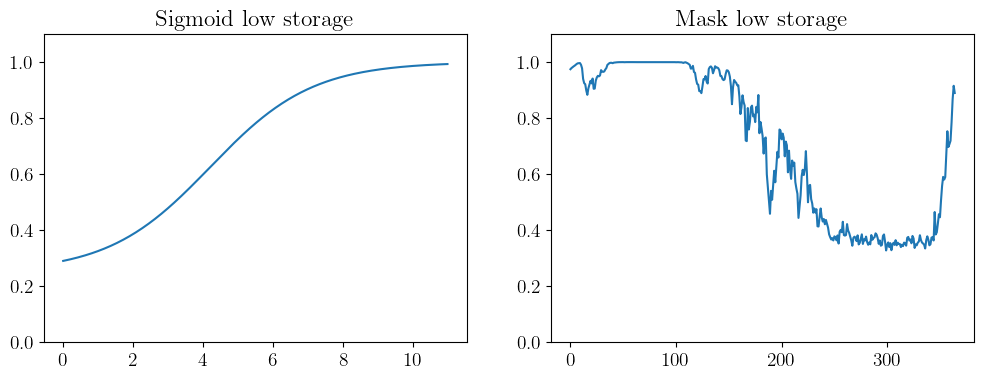

In [28]:
i=2

sig_hydro = sigmoid(inflection=0.05 * max_storage, max_q=1/2 * max_outflow, left=1 / 4, right=1)
factor_hydro = sig_hydro(iqr_stor)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.linspace(0,1/2 * np.max(iqr_stor), 365), 
         sig_hydro(np.linspace(0,1/2 * np.max(iqr_stor), 365)))
#ax1.axvline(x=150)
ax1.set_title("Sigmoid low storage")
ax1.set_ylim(0, 1.1 )

ax2.set_title("Mask low storage")
ax2.plot(np.arange(0,365), factor_hydro[i * 365: (i + 1) * 365])
ax2.set_ylim(0,1.1)

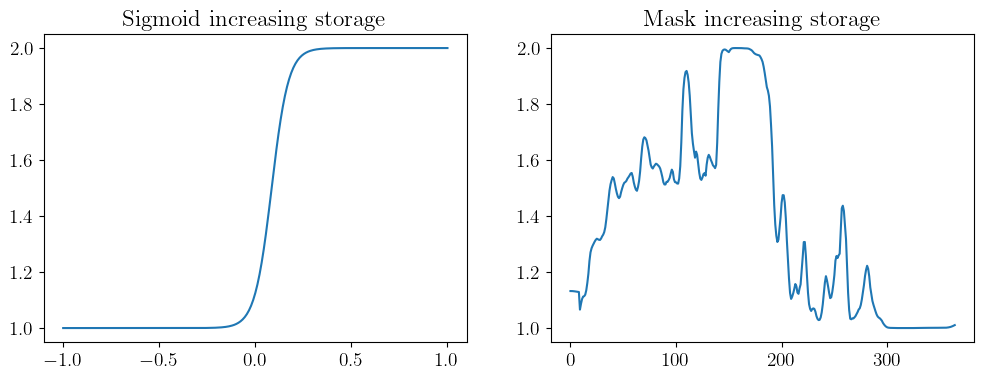

In [59]:
i = 14

sig_increasing_pos = sigmoid(inflection=threshold, max_q=abs(np.max(m) - np.min(m)), left=1, right=2)
mask_increasing_pos = sig_increasing_pos(m)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.linspace(-1,1, 365), 
         sig_increasing_pos(np.linspace(-1,1, 365)))
#ax1.axvline(x=150)
ax1.set_title("Sigmoid increasing storage")
#ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("Mask increasing storage")
ax2.plot(np.arange(0,365), mask_increasing_pos[i * 365: (i + 1) * 365])
#ax2.plot(np.arange(0,365), np.ones(365) * threshold, "r")
#ax2.plot(np.arange(0,365), - np.ones(365) * threshold, "r")



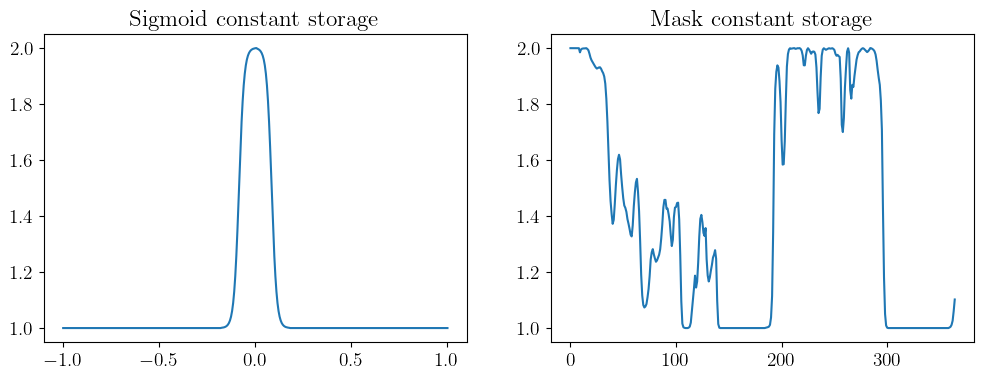

In [67]:
i = 14

f_const = mask_funct(inflection_1=- threshold, inflection_2=threshold, max_q=0.3* abs(np.max(m) - np.min(m)),
                     left=1, center=2, right=1)
mask_const = f_const(m)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.linspace(-1,1, 365), 
         f_const(np.linspace(-1,1, 365)))
#ax1.axvline(x=150)
ax1.set_title("Sigmoid constant storage")
#ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("Mask constant storage")
ax2.plot(np.arange(0,365), mask_const[i * 365: (i + 1) * 365])

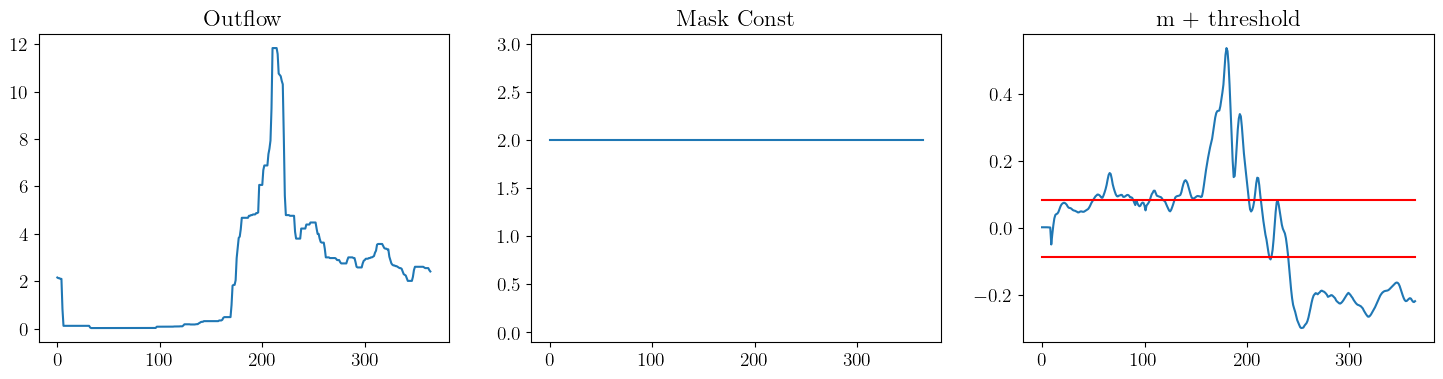

In [34]:
i = 14

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(np.arange(0,365), data["outflow"].iloc[i * 365: (i + 1) * 365])
ax1.set_title("Outflow")

ax2.set_title("Mask Const")
ax2.plot(np.arange(0,365), mask_mean_med[i * 365: (i + 1) * 365])
ax2.set_ylim(-0.1, 3.1)

ax3.set_title("m + threshold")
ax3.plot(np.arange(0,365), m[i * 365: (i + 1) * 365])
ax3.plot(np.arange(0,365), np.ones(365) * threshold, "r")
ax3.plot(np.arange(0,365), - np.ones(365) * threshold, "r")

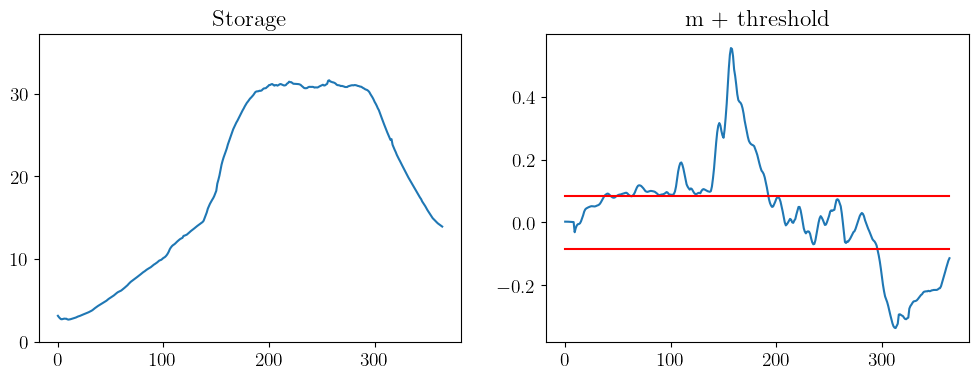

In [68]:
i=14

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(np.arange(0,365), data["storage"].iloc[i * 365: (i + 1) * 365])
#ax1.axvline(x=150)
ax1.set_title("Storage")
ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("m + threshold")
ax2.plot(np.arange(0,365), m[i * 365: (i + 1) * 365])
ax2.plot(np.arange(0,365), np.ones(365) * threshold, "r")
ax2.plot(np.arange(0,365), - np.ones(365) * threshold, "r")

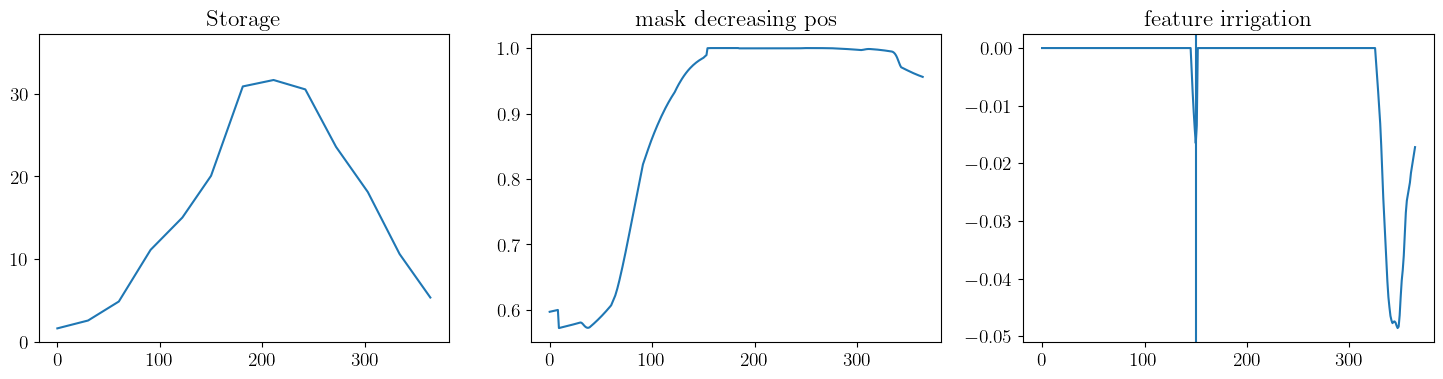

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(np.arange(0,365), data["storage"].iloc[i * 365: (i + 1) * 365])
#ax1.axvline(x=150)
ax1.set_title("Storage")
ax1.set_ylim(0, 1.2 * max_storage )

ax2.set_title("mask decreasing pos")
#ax2.axvline(x=150)
ax2.plot(np.arange(0,365), mask_storage_low_neg[i * 365: (i + 1) * 365])


ax3.set_title("feature irrigation")
ax3.axvline(x=150)
ax3.plot(np.arange(0,365), feature_irr[i * 365: (i + 1) * 365])